### a) Construcción del dataframe

In [1]:
import urllib
import pandas as pd
import numpy as np
from collections import Counter
%matplotlib inline

train_data_url = "http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/vowel.train"
test_data_url = "http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/vowel.test"

train_data_f = urllib.urlretrieve(train_data_url, "train_data.csv")
test_data_f = urllib.urlretrieve(test_data_url, "test_data.csv")

train_df = pd.DataFrame.from_csv('train_data.csv', header=0, index_col=0)
test_df = pd.DataFrame.from_csv('test_data.csv', header=0, index_col=0)

print "Cantidad de clases: ", train_df.shape[1]
print "Registros en el conjunto de entrenamiento: ", train_df.shape[0]
print "Registros en el conjunto de prueba: ", test_df.shape[0]
print "Cantidad de palabras por clase:"
print np.array(sorted(Counter(train_df.ix[:,'y'].values).items())).T[0]

#train_df.describe()
#train_df.head()
#test_df.tail()

Cantidad de clases:  11
Registros en el conjunto de entrenamiento:  528
Registros en el conjunto de prueba:  462
Cantidad de palabras por clase:
[ 1  2  3  4  5  6  7  8  9 10 11]


El conjunto de entrenamiento tiene 528 registos y el de prueba tiene 462 registros. Además, en el conjunto de entrenamiento cada una de las 11 clases tiene 48 palabras.

### b) Construcción de matrices y Normalización

In [2]:
from sklearn.preprocessing import StandardScaler
X = train_df.ix[:,'x.1':'x.10'].values
y = train_df.ix[:,'y'].values

X_std = StandardScaler().fit_transform(X)

### C) PCA

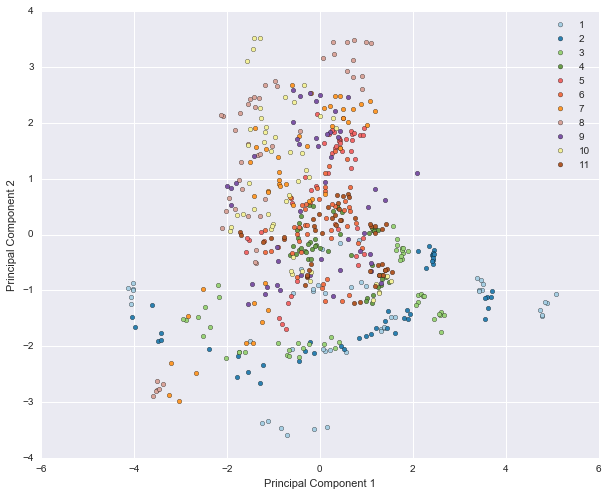

In [3]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

sklearn_pca = PCA(n_components=2)
Xred_pca = sklearn_pca.fit_transform(X_std)
cmap = plt.cm.get_cmap('Paired') # Paleta de color cualitativo para diferenciar cada clase
mclasses=(1,2,3,4,5,6,7,8,9,10,11)
mcolors = [cmap(i) for i in np.linspace(0,1,11)]
plt.figure(figsize=(10, 8))

for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xred_pca[y==lab, 0], Xred_pca[y==lab, 1], label=lab, c=col)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
leg = plt.legend(loc='upper right', fancybox=True)

plt.show()

### d) LDA

C:\Users\theda\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


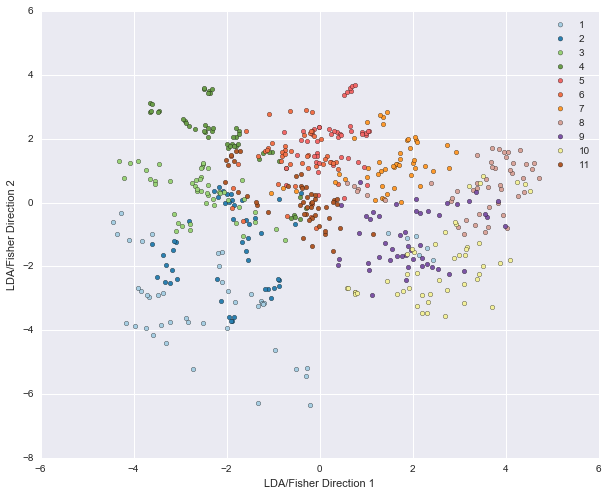

In [4]:
from sklearn.lda import LDA

sklearn_lda = LDA(n_components=2)
Xred_lda = sklearn_lda.fit_transform(X_std,y)
cmap = plt.cm.get_cmap('Paired') # Paleta de color cualitativo para diferenciar cada clase
mclasses=(1,2,3,4,5,6,7,8,9,10,11)
mcolors = [cmap(i) for i in np.linspace(0,1,11)]
plt.figure(figsize=(10, 8))

for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xred_lda[y==lab, 0], Xred_lda[y==lab, 1], label=lab, c=col)

plt.xlabel('LDA/Fisher Direction 1')
plt.ylabel('LDA/Fisher Direction 2')
leg = plt.legend(loc='upper right', fancybox=True)

plt.show()

### e) Comparación cualitativa de PCA y LDA

Como se observa en el caso de PCA hay una mayor sobreposición de las clases que en LDA (prácticamente en PCA no se logra visualizar alguna separación entre las clases). Lo anterior se puede explicar por el hecho de que LDA toma en consideración las etiquetas de las clases, calculando las direcciones que maximizan la separación entre múltiples clases. En cambio, PCA se queda con las direcciones de máxima variabilidad sin considerar la clase de cada dato. Por tanto, LDA es más adecuado para reducción de dimensionalidad cuando los datos son etiquetados.

### f) Clasificador a-priori

In [5]:
def clasificador_a_priori(y_train):
    clases = np.unique(y_train)
    counts = np.array(sorted(Counter(y_train).items()))[:, 1]
    prob = counts.astype(float)/len(y_train)
    prediction = np.random.choice(clases, 1, p=prob)
    return prediction[0]

pred = clasificador_a_priori(y)
print 'Clase a-priori:', pred

Clase a-priori: 7


**Notar que:** Cada una de las clases tiene la misma probabilidad de ser elegidas, debido a que cada una de las clases tiene 48 ocurrencias en el conjunto de entrenamiento.

### g) LDA, QDA y k-NN

Modelo               Score training set   Score testing set
LDA                      0.6837               0.4524               
QDA                      0.9886               0.4156               
k-NN                     0.9318               0.4913               


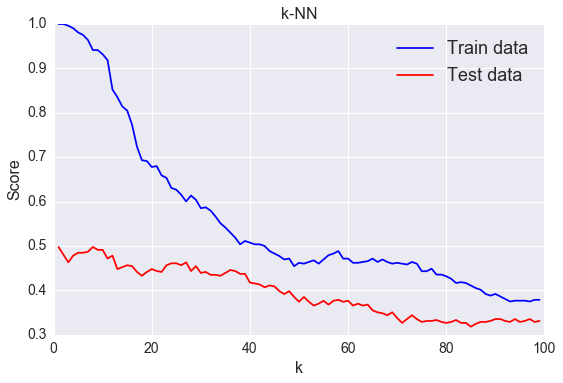

In [7]:
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.neighbors import KNeighborsClassifier
Xtest = test_df.ix[:,'x.1':'x.10'].values
ytest = test_df.ix[:,'y'].values
X_std_test = StandardScaler().fit_transform(Xtest)
lda_model = LDA()
lda_model.fit(X_std,y)

print "{:20} {:20} {:}".format('Modelo','Score training set', 'Score testing set')
print "{:20} {:10.4} {:^35.4}".format('LDA', lda_model.score(X_std,y), lda_model.score(X_std_test,ytest))

qda_model = QDA()
qda_model.fit(X_std,y)
print "{:20} {:10.4} {:^35.4}".format('QDA', qda_model.score(X_std,y), qda_model.score(X_std_test,ytest))

knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_std,y)
print "{:20} {:10.4} {:^35.4}".format('k-NN', knn_model.score(X_std,y), knn_model.score(X_std_test,ytest))

knn_model_train = []
knn_model_test = []
for k in range(1, 100):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_std, y)
    knn_model_train.append((k, knn_model.score(X_std, y)))
    knn_model_test.append((k, knn_model.score(X_std_test, ytest)))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(*zip(*knn_model_train), color="b", linestyle="-", label="Train data")
ax.plot(*zip(*knn_model_test), color="r", linestyle="-", label="Test data")

ax.set_xlabel('k', fontsize=16)
ax.set_ylabel('Score', fontsize=16)
ax.legend(loc=1, prop={'size': 18}, frameon=False)
ax.tick_params(labelsize=14)
plt.title('k-NN', fontsize=16)
fig.tight_layout()
plt.show()

QDA es la técnica que mejor se comporta en el conjunto de entrenamiento con un score del $98.86\%$, seguido bastante de cerca por k-NN con un $93.18\%$. Sin embargo, en el conjunto de prueba QDA es la técnica que posee el peor desempeño ($41.56\%$). Esto puede explicarse debido a que QDA al ser una técnica más compleja se sobre ajusta más al conjunto de entrenamiento repercutiendo en sus predicciones. También, se observa el efecto contrario en LDA, que a pesar de tener un score bajo en el conjunto de entrenamiento, logra un desempeño aceptable en el conjunto de prueba (no existe una caída sustancial en el score de LDA en comparación a los otros dos métodos). k-NN es el que logra un mayor score en el conjunto de prueba con un $49.13\%$.

También, se puede observar en el gráfico que a medida que k aumenta, la precisión del método k-NN va disminuyendo, esto se debe a que en general un vecindario más pequeño se comporta mejor que uno muy grande, ya que en vecindarios grandes las relaciones locales fuertes se ven opacadas por las muchas débiles.

### h) Reducción de dimensionalidad con PCA

Modelo               Min error test       Max score test       Dimensiones
LDA                      0.5476             0.4524                 10     
k-NN                     0.5065             0.4935                 6      
QDA                      0.5584             0.4416                 6      


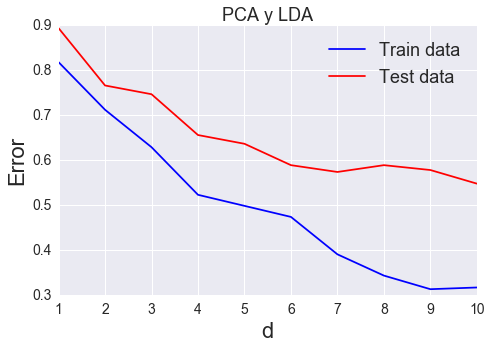

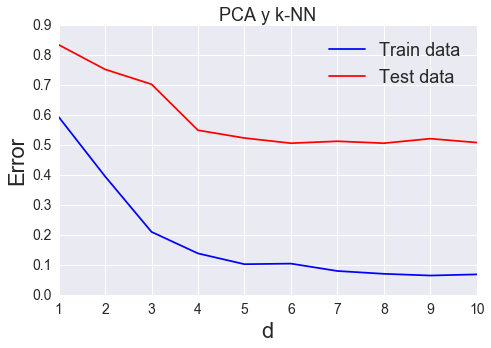

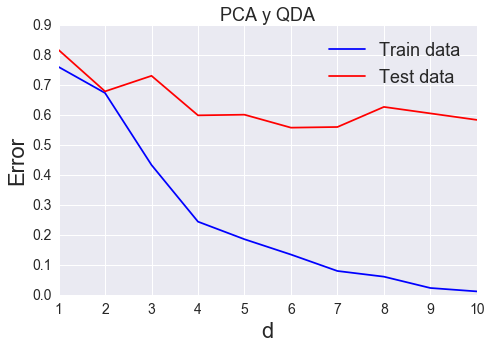

In [8]:
models_data = {model: {'train': [], 'test': []} for model in ['LDA', 'QDA', 'k-NN']}

for d in range(1, 11):
    pca = PCA(n_components=d)
    Xred_pca = pca.fit_transform(X_std)
    Xred_pca_test = pca.transform(X_std_test)

    # lda
    lda_model = LDA()
    lda_model.fit(Xred_pca, y)
    # qda
    qda_model = QDA()
    qda_model.fit(Xred_pca, y)
    # knn
    knn_model = KNeighborsClassifier(n_neighbors=10)
    knn_model.fit(Xred_pca, y)

    # Train error
    models_data['LDA']['train'].append((d, 1 - lda_model.score(Xred_pca, y)))
    models_data['QDA']['train'].append((d, 1 - qda_model.score(Xred_pca, y)))
    models_data['k-NN']['train'].append((d, 1 - knn_model.score(Xred_pca, y)))

    # Test error
    models_data['LDA']['test'].append((d, 1 - lda_model.score(Xred_pca_test, ytest)))
    models_data['QDA']['test'].append((d, 1 - qda_model.score(Xred_pca_test, ytest)))
    models_data['k-NN']['test'].append((d, 1 - knn_model.score(Xred_pca_test, ytest)))

print "{:20} {:20} {:20} {:}".format('Modelo','Min error test', 'Max score test', 'Dimensiones')
for model, data in models_data.items():
    print "{:20} {:10.4} {:^30.4} {:^10} ".format(model, min(data['test'], key=lambda t: t[1])[1],
                                         1 - min(data['test'], key=lambda t: t[1])[1],
                                         min(data['test'], key=lambda t: t[1])[0])
         
    
for model, data in models_data.items():
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)    
    ax.plot(*zip(*data['train']), color="b", linestyle="-", label="Train data")
    ax.plot(*zip(*data['test']), color="r", linestyle="-", label="Test data")
    ax.set_xlabel('d', fontsize=22)
    ax.set_ylabel('Error', fontsize=22)
    ax.legend(loc=1, prop={'size': 18}, frameon=False)
    ax.tick_params(labelsize=14)
    ax.set_title('PCA y ' + model, fontsize=18)
    fig.tight_layout()
    plt.show()

Al reducir dimensionalidad con PCA, se observa que en los tres modelos de clasificación (LDA, QDA y k-NN) el error de entrenamiento decrece paulatinamente en la medida que se va aumentando el número de componentes principales. El error de prueba es siempre mayor al error de entrenamiento, esto se debe a que para calcular el error de entrenamiento se clasifican los mismos datos con los que se entrena el modelo. En general, el modelo PCA k-NN es el que presenta menor error utilizando 6 componentes. Si comparamos los resultados con la pregunta anterior (g), se puede notar que aplicar PCA prácticamente no mejora la precisión de los métodos. Esto se debe principalmente a que PCA no es un método que funcione bien en conjuntos de datos etiquetados.

### i) Reducción de dimensionalidad con LDA

Modelo               Min error test       Max score test       Dimensiones
LDA                     0.51299            0.48701                 2      
k-NN                    0.45022            0.54978                 9      
QDA                     0.48701            0.51299                 2      


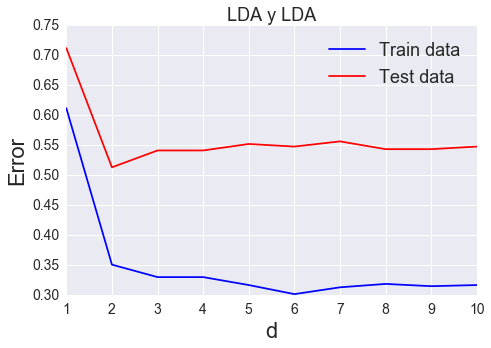

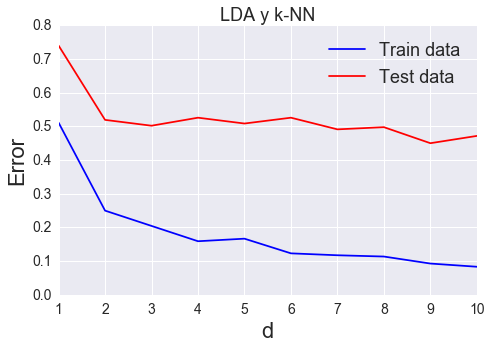

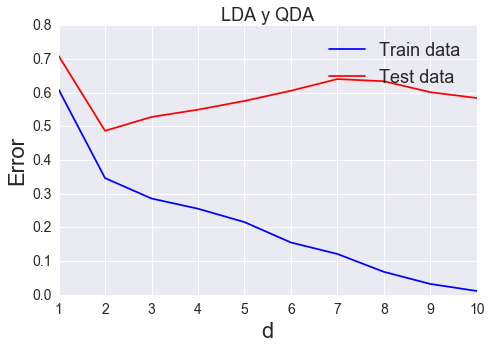

In [9]:
models_data = {model: {'train': [], 'test': []} for model in ['LDA', 'QDA', 'k-NN']}

for d in range(1, 11):
    lda = LDA(n_components=d)
    Xred_lda = lda.fit_transform(X_std, y)
    Xred_lda_test = lda.transform(X_std_test)

    # lda
    lda_model = LDA()
    lda_model.fit(Xred_lda, y)
    # qda
    qda_model = QDA()
    qda_model.fit(Xred_lda, y)
    # knn
    knn_model = KNeighborsClassifier(n_neighbors=10)
    knn_model.fit(Xred_lda, y)

    # Train error
    models_data['LDA']['train'].append((d, 1 - lda_model.score(Xred_lda, y)))
    models_data['QDA']['train'].append((d, 1 - qda_model.score(Xred_lda, y)))
    models_data['k-NN']['train'].append((d, 1 - knn_model.score(Xred_lda, y)))

    # Test error
    models_data['LDA']['test'].append((d, 1 - lda_model.score(Xred_lda_test, ytest)))
    models_data['QDA']['test'].append((d, 1 - qda_model.score(Xred_lda_test, ytest)))
    models_data['k-NN']['test'].append((d, 1 - knn_model.score(Xred_lda_test, ytest)))

print "{:20} {:20} {:20} {:}".format('Modelo','Min error test', 'Max score test', 'Dimensiones')
for model, data in models_data.items():
    print "{:20} {:10.5} {:^30.5} {:^10} ".format(model, min(data['test'], key=lambda t: t[1])[1],
                                         1 - min(data['test'], key=lambda t: t[1])[1],
                                         min(data['test'], key=lambda t: t[1])[0])

for model, data in models_data.items():
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)    
    ax.plot(*zip(*data['train']), color="b", linestyle="-", label="Train data")
    ax.plot(*zip(*data['test']), color="r", linestyle="-", label="Test data")
    ax.set_xlabel('d', fontsize=22)
    ax.set_ylabel('Error', fontsize=22)
    ax.legend(loc=1, prop={'size': 18}, frameon=False)
    ax.tick_params(labelsize=14)
    ax.set_title('LDA y ' + model, fontsize=18)
    fig.tight_layout()
    plt.show()

De manera similar, se observa que el error de entrenamiento disminuye conforme aumenta el número de componentes principales. No obstante, al reducir dimensionalidad con LDA si se logran mejoras en los modelos para el error de prueba, siendo k-NN el que logra el menor error al considerar 9 componentes. También se debe resaltar, que en los modelos LDA y QDA alcanzan su menor error de prueba con tan sólo 2 componentes principales, volviendo al modelo QDA bastante atractivo en términos de eficacia y complejidad, ya que el modelo es más simple al utilizar sólo 2 componentes principales en comparación a las 9 que utiliza k-NN. Estos resultados reafirman lo dicho anteriormente en el ítem (c), que LDA es una técnica adecuada para reducir dimensionalidad en problemas de clasificación a diferencia de PCA.